# Power-Law Patterns in Sentence Context Vector Clustering (Romance Book)


**Dataset Used:**
- Project Gutenberg eBook of [Sense and Sensibility by Jane Austen](https://www.gutenberg.org/ebooks/161)
- Genre: Love

# Outline:

1. Collects a large continous text (3000 sentences)
2. Computes each sentence’s embedding with [StoryEmb model](https://huggingface.co/uhhlt/story-emb) (built onMistral), all-mpnet-base-v2 (sentence-transformer), all-distilroberta-v1 (sentence-transformer).
4. Calculates pairwise cosine similarities between the embeddings.
5. Assumes the similarity of 0.90 and above as similar sentences. Counts the number of the similar sentences. Adds the number of words on each group as a sanity check.
6. Stores the group counts in a vector, rearrange it, and plot count (y-axis) versus matrix index (x-axis).
7. Plots the log log plot using the count matrix.

# Data Load

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import re
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt_tab')

# load raw text
with open('/content/drive/MyDrive/Colab Notebooks/sense_and_sensibility.txt', 'r', encoding='utf-8') as f:
    raw_text = f.read()

# remove start & end blocks
def strip_gutenberg_boilerplate(text: str) -> str:
    start = r'\*\*\* START OF (?:THE|THIS) PROJECT GUTENBERG EBOOK .*? \*\*\*'
    end   = r'\*\*\* END OF (?:THE|THIS) PROJECT GUTENBERG EBOOK .*? \*\*\*'
    text  = re.split(start, text, 1, flags=re.I | re.S)[-1]
    text  = re.split(end,   text, 1, flags=re.I | re.S)[0]
    return text

# remove contents, chapter heads, illustration notes
def extra_cleanup(text: str) -> str:
    text = re.sub(r'\[Illustration.*?\n', ' ', text, flags=re.I)
    text = re.sub(r'Contents.+?CHAPTER\s+I\.', ' ', text,
                  flags=re.I | re.S)

    text = re.sub(r'CHAPTER\s+[IVXLCDM]+\s*\.', ' ', text,
                  flags=re.I)

    # normalise whitespace and remove stray markup chars
    text = re.sub(r'[_*"#]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
clean_text  = strip_gutenberg_boilerplate(raw_text)
clean_text  = extra_cleanup(clean_text)
sentences_cleaned   = sent_tokenize(clean_text)

print(f"cleaned text: {len(sentences_cleaned):,} sentences")


cleaned text: 3,922 sentences


In [ ]:
# get the middle 3000 sentences
total = len(sentences_cleaned)
middle_start = max((total // 2) - 1500, 0)
middle_end = min((total // 2) + 1500, total)

sentences = sentences_cleaned[middle_start:middle_end]

print(f"extracted {len(sentences)} middle sentences (from {middle_start} to {middle_end})")

print(sentences)

extracted 3000 middle sentences (from 461 to 3461)
['“Willoughby!” cried Sir John; “what, is he in the country?', 'That is good news however; I will ride over tomorrow, and ask him to dinner on Thursday.” “You know him then,” said Mrs. Dashwood.', '“Know him!', 'to be sure I do.', 'Why, he is down here every year.” “And what sort of a young man is he?” “As good a kind of fellow as ever lived, I assure you.', 'A very decent shot, and there is not a bolder rider in England.” “And is that all you can say for him?” cried Marianne, indignantly.', '“But what are his manners on more intimate acquaintance?', 'What his pursuits, his talents, and genius?” Sir John was rather puzzled.', '“Upon my soul,” said he, “I do not know much about him as to all that.', 'But he is a pleasant, good humoured fellow, and has got the nicest little black bitch of a pointer I ever saw.', 'Was she out with him today?” But Marianne could no more satisfy him as to the colour of Mr. Willoughby’s pointer, than he coul

In [ ]:
import json

output_path = "/content/sense_and_sensibility_3000_sentences.json"

with open(output_path, "w", encoding="utf-8") as f:
    json.dump(sentences, f, ensure_ascii=False, indent=4)

print(f"saved {len(sentences)} sentences to {output_path}")


saved 3000 sentences to /content/sense_and_sensibility_3000_sentences.json


# Load LLM models & Compute Embedding Vectors

In [ ]:
!pip install sentence-transformers

In [ ]:
# model 1: load StoryEmb model (transformers-based)
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np

# load StoryEmb model
model_name = "uhhlt/story-emb"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model1 = AutoModel.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")

def get_embedding1(model, tokenizer, sentences, batch_size=16):
  embeddings = []

  # batch processing
  for i in range(0, len(sentences), batch_size):
    batch = sentences[i:i+batch_size]
    inputs = tokenizer(
      batch,
      padding=True,
      truncation=True,
      max_length=256,
      return_tensors="pt"
    ).to(model.device)

    with torch.no_grad():
      outputs = model(**inputs)

    batch_embeddings = outputs.last_hidden_state[:, 0, :]
    embeddings.append(batch_embeddings.cpu())

  return torch.cat(embeddings, dim=0).numpy()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/669 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# initialize models 2 & 3
from sentence_transformers import SentenceTransformer
# model 2: all-mpnet-base-v2
model2 = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
# model 3: all-distilroberta-v1
model3 = SentenceTransformer('sentence-transformers/all-distilroberta-v1')

def get_embedding2(model, sentences):
  embeddings = model.encode(sentences)
  return embeddings



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# get embeddings StoryEmb
embeddings1 = get_embedding1(model1, tokenizer, sentences, batch_size=16)
print("StoryEmb Embeddings Shape:", embeddings1.shape)

StoryEmb Embeddings Shape: (3000, 4096)


In [ ]:
# get embeddings all-mpnet-base-v2
embeddings2 = get_embedding2(model2, sentences)
print("all-mpnet-base-v2 Embeddings Shape:", embeddings2.shape)

all-mpnet-base-v2 Embeddings Shape: (3000, 768)


In [ ]:
# get embeddings all-distilroberta-v1
embeddings3 = get_embedding2(model3, sentences)
print("all-distilroberta-v1 Embeddings Shape:", embeddings3.shape)

all-distilroberta-v1 Embeddings Shape: (3000, 768)


### Compute the inter vector Cosine similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cos_similar1 = cosine_similarity(embeddings1)
cos_similar2 = cosine_similarity(embeddings2)
cos_similar3 = cosine_similarity(embeddings3)

In [ ]:
print("storyemb Cosine Similarity")
print(np.round(cos_similar1[:5, :5], 2))

storyemb Cosine Similarity
[[1.   0.89 0.95 0.95 0.9 ]
 [0.89 1.   0.83 0.83 0.91]
 [0.95 0.83 1.   1.   0.84]
 [0.95 0.83 1.   1.   0.85]
 [0.9  0.91 0.84 0.85 1.  ]]


In [ ]:
print("all-mpnet-base-v2 Cosine Similarity")
print(np.round(cos_similar2[:5, :5], 2))

all-mpnet-base-v2 Cosine Similarity
[[1.   0.23 0.32 0.08 0.41]
 [0.23 1.   0.45 0.24 0.34]
 [0.32 0.45 1.   0.21 0.49]
 [0.08 0.24 0.21 1.   0.18]
 [0.41 0.34 0.49 0.18 1.  ]]


In [ ]:
print("all-distilroberta-v1 Cosine Similarity")
print(np.round(cos_similar3[:5, :5], 2))

all-distilroberta-v1 Cosine Similarity
[[1.   0.23 0.3  0.07 0.45]
 [0.23 1.   0.39 0.22 0.35]
 [0.3  0.39 1.   0.2  0.41]
 [0.07 0.22 0.2  1.   0.13]
 [0.45 0.35 0.41 0.13 1.  ]]


## Grouping and Clustering
- Now assuming the similarity of ex) 0.9 and above as similar sentences, count the number of these similar sentences. Alert, since counting can occur in different ways, do not count a particular sentence more than once. Add the number of words on each group as a sanity check.

In [ ]:
pip install hdbscan umap-learn

In [ ]:
n = len(sentences)

In [ ]:
# Kmeans clustering
from sklearn.cluster import KMeans

kmeans1 = KMeans(n_clusters=34, random_state=42)
kmeans2 = KMeans(n_clusters=20, random_state=42)
kmeans3 = KMeans(n_clusters=26, random_state=42)

cluster_labels1 = kmeans1.fit_predict(embeddings1)
cluster_labels2 = kmeans2.fit_predict(embeddings2)
cluster_labels3 = kmeans3.fit_predict(embeddings3)

In [ ]:
#using HDBSCAN for clustering
import random
from functools import partial
import hdbscan
import umap
import tensorflow as tf
import tensorflow_hub as hub
from sentence_transformers import SentenceTransformer
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from tqdm.notebook import trange
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials

def hdbscan_clusters(message_embeddings,
                      n_neighbors,
                      n_components,
                      min_cluster_size,
                      min_samples = None,
                      random_state = None):

    umap_embeddings = (umap.UMAP(n_neighbors = n_neighbors,
                                n_components = n_components,
                                metric = 'cosine',
                                random_state=random_state)
                            .fit_transform(message_embeddings))

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size,
                               min_samples = min_samples,
                               metric='euclidean',
                               gen_min_span_tree=True,
                               cluster_selection_method='eom').fit(umap_embeddings)

    return clusters

In [ ]:
#generating clusters
hdbscan_group1 = hdbscan_clusters(embeddings1,
                                     n_neighbors = 5,
                                     n_components = 2,
                                     min_cluster_size = 3,
                                     random_state=42)

hdbscan_group2 = hdbscan_clusters(embeddings2,
                                     n_neighbors = 15,
                                     n_components = 10,
                                     min_cluster_size = 3,
                                     random_state=42)


hdbscan_group3 = hdbscan_clusters(embeddings3,
                                     n_neighbors = 9,
                                     n_components = 4,
                                     min_cluster_size = 3,
                                     random_state=42)

# cluster labels
labels_hdbscan1 = hdbscan_group1.labels_
labels_hdbscan2 = hdbscan_group2.labels_
labels_hdbscan3 = hdbscan_group3.labels_

# count unique clusters (excluding noise points labeled as -1)
num_clusters_group1 = len(set(labels_hdbscan1)) - (1 if -1 in labels_hdbscan1 else 0)
num_clusters_group2 = len(set(labels_hdbscan2)) - (1 if -1 in labels_hdbscan2 else 0)
num_clusters_group3 = len(set(labels_hdbscan3)) - (1 if -1 in labels_hdbscan3 else 0)

print(f"Number of clusters in Group 1: {num_clusters_group1}")
print(f"Number of clusters in Group 2: {num_clusters_group2}")
print(f"Number of clusters in Group 3: {num_clusters_group3}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be 

Number of clusters in Group 1: 245
Number of clusters in Group 2: 181
Number of clusters in Group 3: 189


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Count number of sentences & number of words

In [ ]:
from nltk.tokenize import word_tokenize

print("--K-Means--")

def count_words_per_cluster(sentences, cluster_labels):
    # group sentences by cluster
    clusters = {}
    for idx, label in enumerate(cluster_labels):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(sentences[idx])

    # count total words per cluster
    word_counts_per_cluster = {}
    for label, cluster_sentences in clusters.items():
        word_count = 0
        for sentence in cluster_sentences:
            word_count += len(word_tokenize(sentence.lower()))
        word_counts_per_cluster[label] = word_count

    return sorted(word_counts_per_cluster.values(), reverse=True)


def count_sentences_per_cluster(cluster_labels):
    unique, counts = np.unique(cluster_labels, return_counts=True)
    return counts


sentences_per_cluster1 = count_sentences_per_cluster(cluster_labels1)
sentences_per_cluster2 = count_sentences_per_cluster(cluster_labels2)
sentences_per_cluster3 = count_sentences_per_cluster(cluster_labels3)

words_per_cluster1 = count_words_per_cluster(sentences, cluster_labels1)
words_per_cluster2 = count_words_per_cluster(sentences, cluster_labels2)
words_per_cluster3 = count_words_per_cluster(sentences, cluster_labels3)

print("Embedding 1")
print("\nSentence counts per cluster in Kmeans1:", sentences_per_cluster1[:5])
print("\nWord counts per cluster in Kmeans1:", words_per_cluster1[:5])

print("Embedding 2")
print("\nSentence counts per cluster in Kmeans2:", sentences_per_cluster2[:5])
print("\nWord counts per cluster in Kmeans2:", words_per_cluster2[:5])

print("Embedding 3")
print("\nSentence counts per cluster in Kmeans3:", sentences_per_cluster3[:5])
print("\nWord counts per cluster in Kmeans3:", words_per_cluster3[:5])


--K-Means--
Embedding 1

Sentence counts per cluster in Kmeans1: [ 22 191  78 167 221]

Word counts per cluster in Kmeans1: [18039, 6042, 4764, 4481, 4100]
Embedding 2

Sentence counts per cluster in Kmeans2: [138 110 127 169 149]

Word counts per cluster in Kmeans2: [17352, 17063, 7603, 7244, 7128]
Embedding 3

Sentence counts per cluster in Kmeans3: [ 88 184 160 105 105]

Word counts per cluster in Kmeans3: [14300, 9229, 6490, 6285, 6188]


In [ ]:
def count_sentences_per_hdbscan_cluster(cluster_labels):
    num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)


    counts = np.zeros(num_clusters, dtype=int)

    for label in cluster_labels:
        if label != -1:  # Skip noise points
            counts[label] += 1

    return counts

def count_words_per_hdbscan_cluster(sentences, cluster_labels):
    # group sentences by cluster, excluding noise points (-1)
    clusters = {}
    for idx, label in enumerate(cluster_labels):
        if label != -1:  # Skip noise points
            if label not in clusters:
                clusters[label] = []
            clusters[label].append(sentences[idx])

    # count total words per cluster
    word_counts_per_cluster = {}
    for label, cluster_sentences in clusters.items():
        word_count = 0
        for sentence in cluster_sentences:
            word_count += len(word_tokenize(sentence.lower()))
        word_counts_per_cluster[label] = word_count

    return sorted(word_counts_per_cluster.values(), reverse=True)

In [ ]:
print("HDBSCAN: ")

# Get number of sentences per cluster in a list format
sentence_counts_hdbscan1 = count_sentences_per_cluster(labels_hdbscan1)
sentence_counts_hdbscan2 = count_sentences_per_cluster(labels_hdbscan2)
sentence_counts_hdbscan3 = count_sentences_per_cluster(labels_hdbscan3)

word_counts_hdbscan1 = count_words_per_hdbscan_cluster(sentences, labels_hdbscan1)
word_counts_hdbscan2 = count_words_per_hdbscan_cluster(sentences, labels_hdbscan2)
word_counts_hdbscan3 = count_words_per_hdbscan_cluster(sentences, labels_hdbscan3)

print("\nEmbedding 1")
print("Sentence counts per cluster in HDBSCAN Group 1:", sentence_counts_hdbscan1[:5])
print("Unique word counts per cluster in HDBSCAN Group 1:", word_counts_hdbscan1[:5])

print("\nEmbedding 2")
print("Sentence counts per cluster in HDBSCAN Group 2:", sentence_counts_hdbscan2[:5])
print("Unique word counts per cluster in HDBSCAN Group 2:", word_counts_hdbscan2[:5])

print("\nEmbedding 3")
print("Sentence counts per cluster in HDBSCAN Group 3:", sentence_counts_hdbscan3[:5])
print("Unique word counts per cluster in HDBSCAN Group 3:", word_counts_hdbscan3[:5])

HDBSCAN: 

Embedding 1
Sentence counts per cluster in HDBSCAN Group 1: [761   6  14   7   5]
Unique word counts per cluster in HDBSCAN Group 1: [4319, 2464, 1557, 1387, 1343]

Embedding 2
Sentence counts per cluster in HDBSCAN Group 2: [1244   16   12   10   15]
Unique word counts per cluster in HDBSCAN Group 2: [5366, 1966, 1827, 1355, 1282]

Embedding 3
Sentence counts per cluster in HDBSCAN Group 3: [1160    8   26   21   21]
Unique word counts per cluster in HDBSCAN Group 3: [2371, 1804, 1236, 1142, 1095]


In [ ]:
# setence count stored in vector
import numpy as np


vector_sent_kmeans1 = np.array(sorted(sentences_per_cluster1, reverse=True))
vector_sent_kmeans2 = np.array(sorted(sentences_per_cluster2, reverse=True))
vector_sent_kmeans3 = np.array(sorted(sentences_per_cluster3, reverse=True))


vector_sent_hdbscan1 = np.array(sorted(sentence_counts_hdbscan1, reverse=True))
vector_sent_hdbscan2 = np.array(sorted(sentence_counts_hdbscan2, reverse=True))
vector_sent_hdbscan3 = np.array(sorted(sentence_counts_hdbscan3, reverse=True))


print("Vector Sent Kmeans 1:", vector_sent_kmeans1)
print("Vector Sent Kmeans 2:", vector_sent_kmeans2)
print("Vector Sent Kmeans 3:", vector_sent_kmeans3)
print("Vector Sent HDBSCAN 1:", vector_sent_hdbscan1)
print("Vector Sent HDBSCAN 2:", vector_sent_hdbscan2)
print("Vector Sent HDBSCAN 3:", vector_sent_hdbscan3)

Vector Sent Kmeans 1: [286 221 219 203 191 167 143 131 118 105  92  79  78  70  68  65  62  60
  56  55  51  51  51  50  49  48  42  38  36  26  26  25  22  16]
Vector Sent Kmeans 2: [344 244 180 169 167 159 158 149 142 138 137 127 127 125 123 112 110 106
 101  82]
Vector Sent Kmeans 3: [184 181 172 171 160 157 149 137 132 112 110 110 105 105  98  96  94  91
  90  88  86  85  80  80  70  57]
Vector Sent HDBSCAN 1: [761  55  45  42  41  38  32  31  31  28  24  23  22  21  20  19  17  17
  17  17  17  16  16  16  16  16  16  15  15  15  15  15  15  15  15  14
  14  14  14  14  14  13  13  13  13  13  13  13  12  12  12  12  12  12
  12  12  12  12  11  11  11  11  11  11  11  11  11  11  10  10  10  10
  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10   9
   9   9   9   9   9   9   9   9   8   8   8   8   8   8   8   8   8   8
   8   8   8   8   8   7   7   7   7   7   7   7   7   7   7   7   7   7
   7   7   7   6   6   6   6   6   6   6   6   6   6   6   6   6   6   

## Plot
- Plot the sentence count in y-axis and matrix index in the x-axis.
- Plot the log log plot using the count matrix.

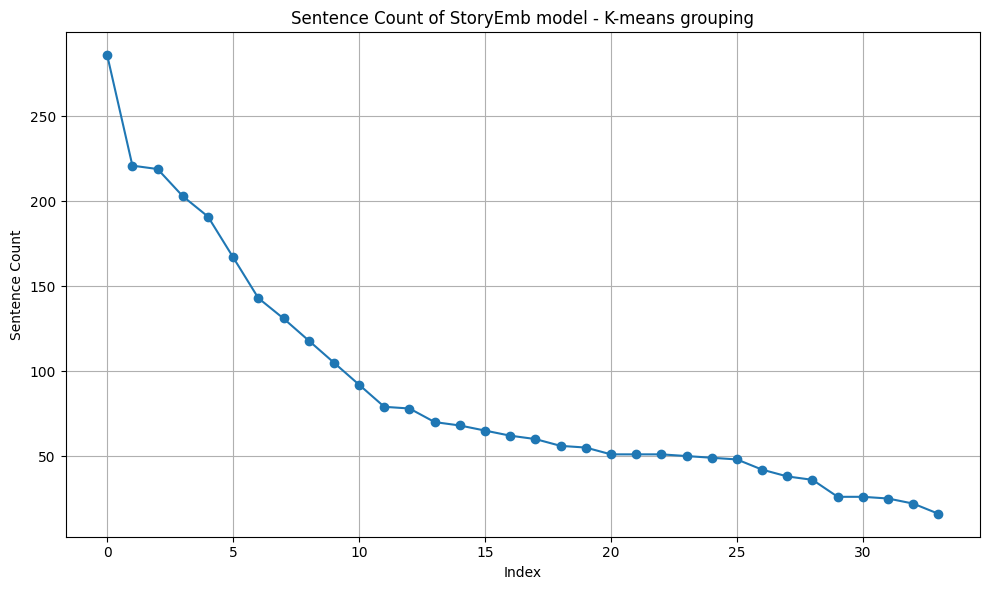

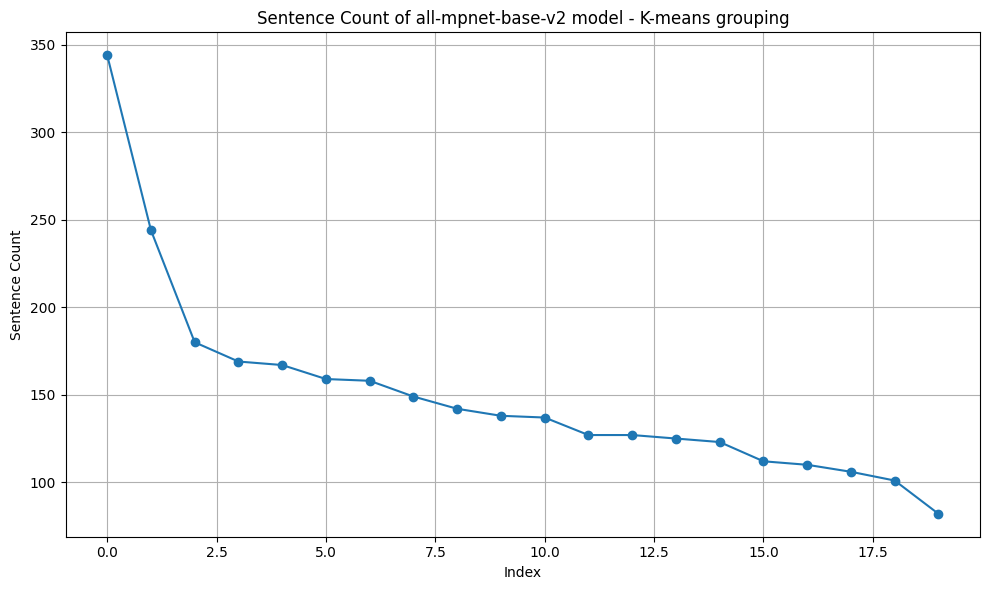

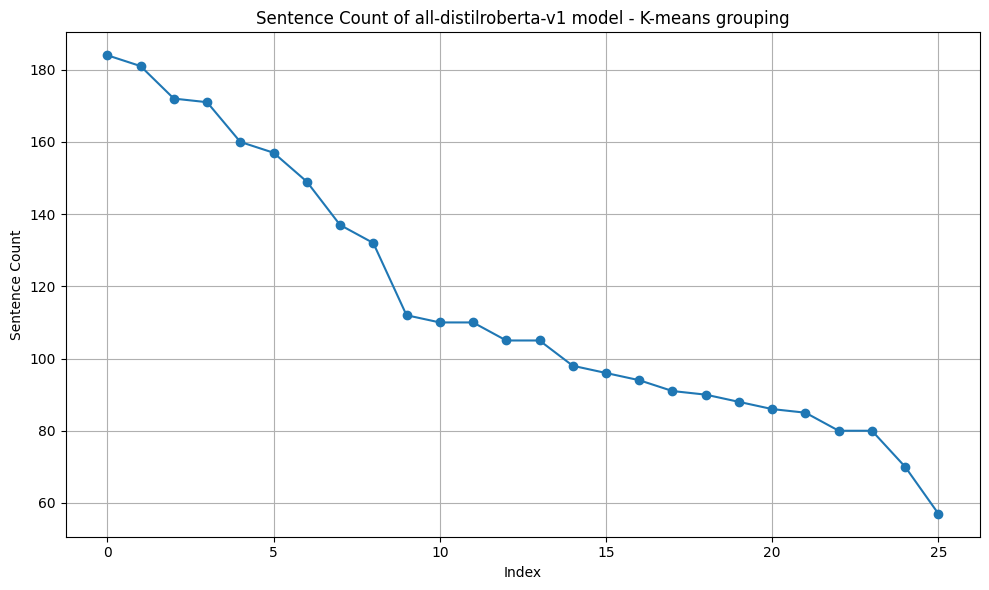

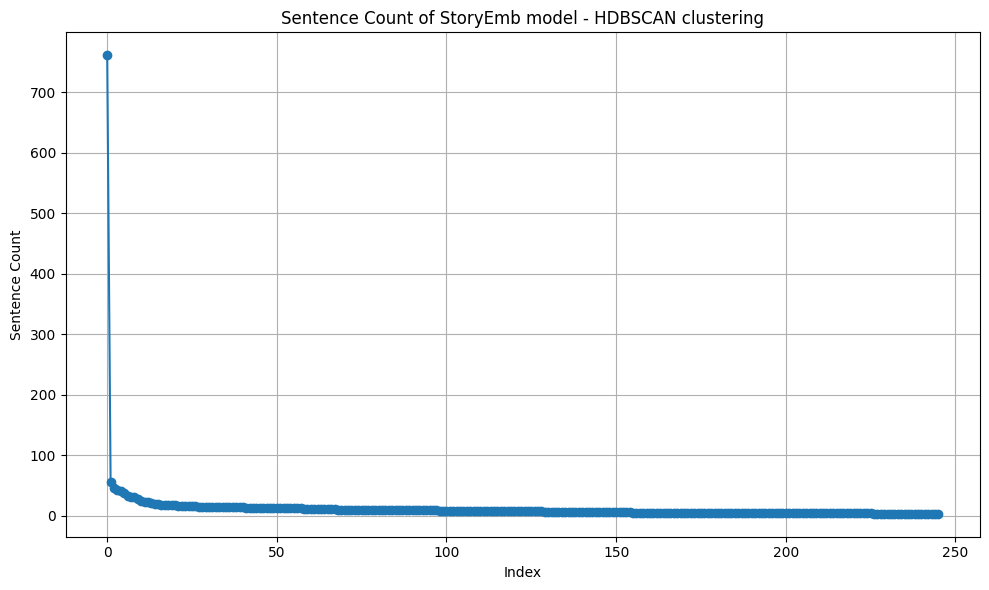

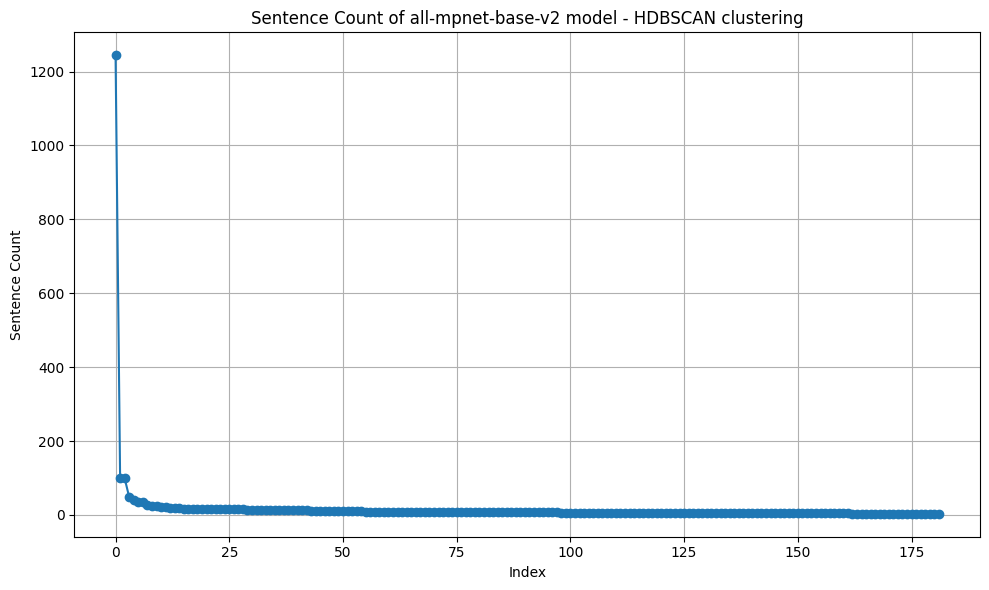

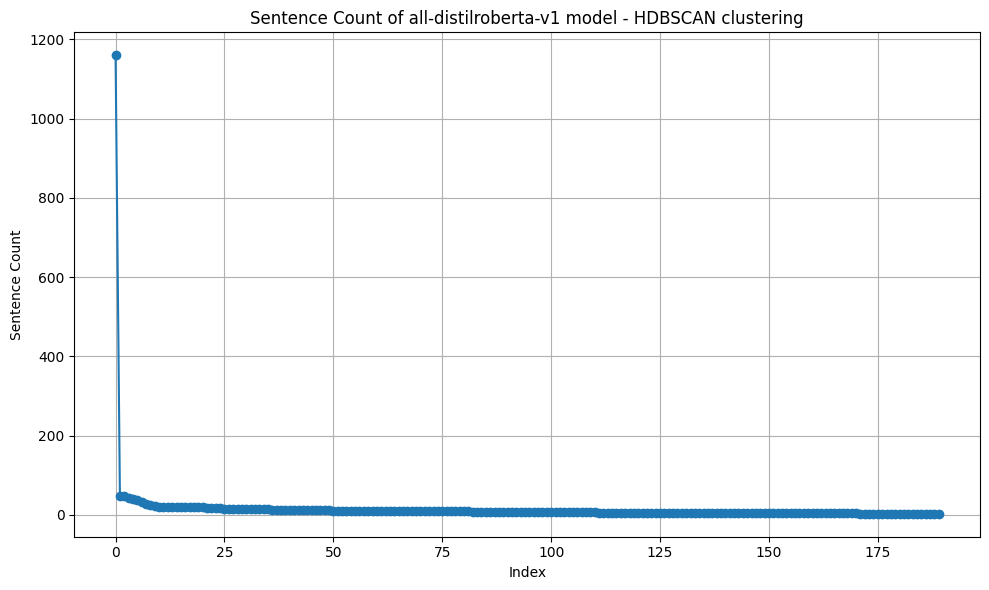

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re

# Create list of vectors and their names
vectors = [
    (vector_sent_kmeans1, "Sentence Count of StoryEmb model - K-means grouping"),
    (vector_sent_kmeans2, "Sentence Count of all-mpnet-base-v2 model - K-means grouping"),
    (vector_sent_kmeans3, "Sentence Count of all-distilroberta-v1 model - K-means grouping"),
    (vector_sent_hdbscan1, "Sentence Count of StoryEmb model - HDBSCAN clustering"),
    (vector_sent_hdbscan2, "Sentence Count of all-mpnet-base-v2 model - HDBSCAN clustering"),
    (vector_sent_hdbscan3, "Sentence Count of all-distilroberta-v1 model - HDBSCAN clustering")
]

# Create the output directory if it doesn't exist
output_dir = "/content/images/"
os.makedirs(output_dir, exist_ok=True)

# Loop through each vector and create its plot
for vector, title in vectors:
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(vector)), vector, marker='o')
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Sentence Count')
    plt.grid(True)
    plt.tight_layout()

    # Create a safe filename from the title
    filename = re.sub(r'[^a-zA-Z0-9_\-]', '_', title) + ".png"
    save_path = os.path.join(output_dir, filename)
    plt.savefig(save_path)
    plt.show()



## Log Log plot - linear regression
- check for power law distribution


In [ ]:
#Linear regression
from scipy.stats import linregress

def linear_regression(counts):
    """Perform linear regression on log-transformed data."""
    # Log transform the data
    x = np.log10(np.arange(1, len(counts)+1))
    y = np.log10(counts)

    # Linear regression
    slope, intercept, r_val, p_val, std_err = linregress(x, y)

    # Regression prediction
    y_pred = slope * x + intercept

    return x, y, slope, intercept, r_val, p_val, y_pred

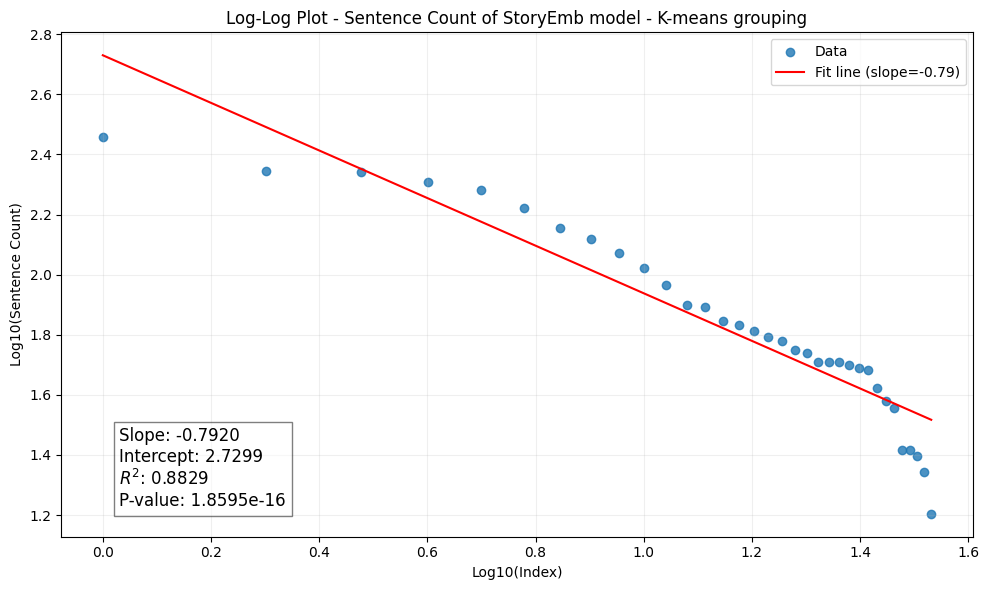


Regression Results for Sentence Count of StoryEmb model - K-means grouping:
   - Slope: -0.7920
   - Intercept: 2.7299
   - R-squared: 0.8829
   - P-value: 1.8595e-16


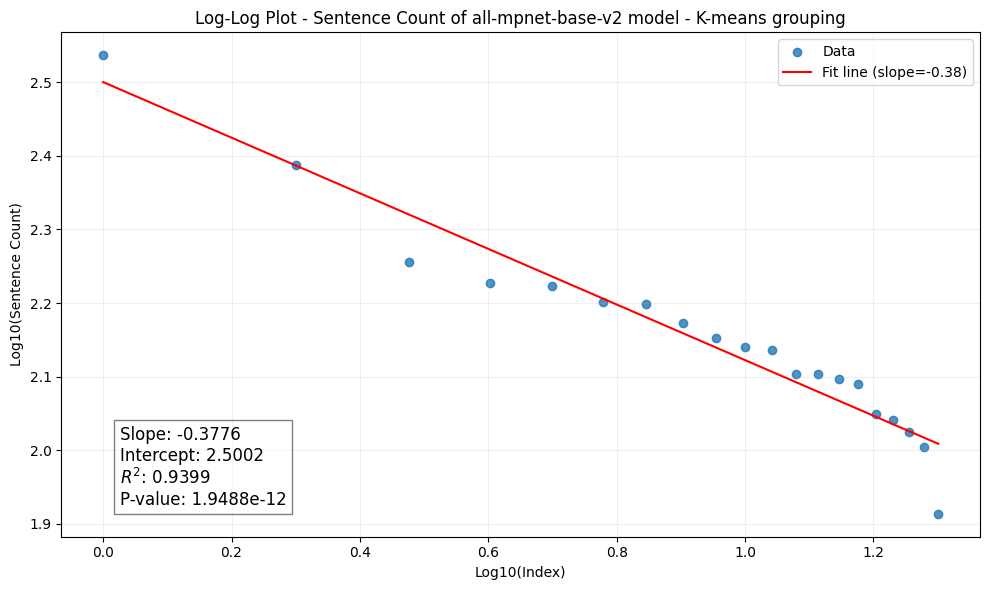


Regression Results for Sentence Count of all-mpnet-base-v2 model - K-means grouping:
   - Slope: -0.3776
   - Intercept: 2.5002
   - R-squared: 0.9399
   - P-value: 1.9488e-12


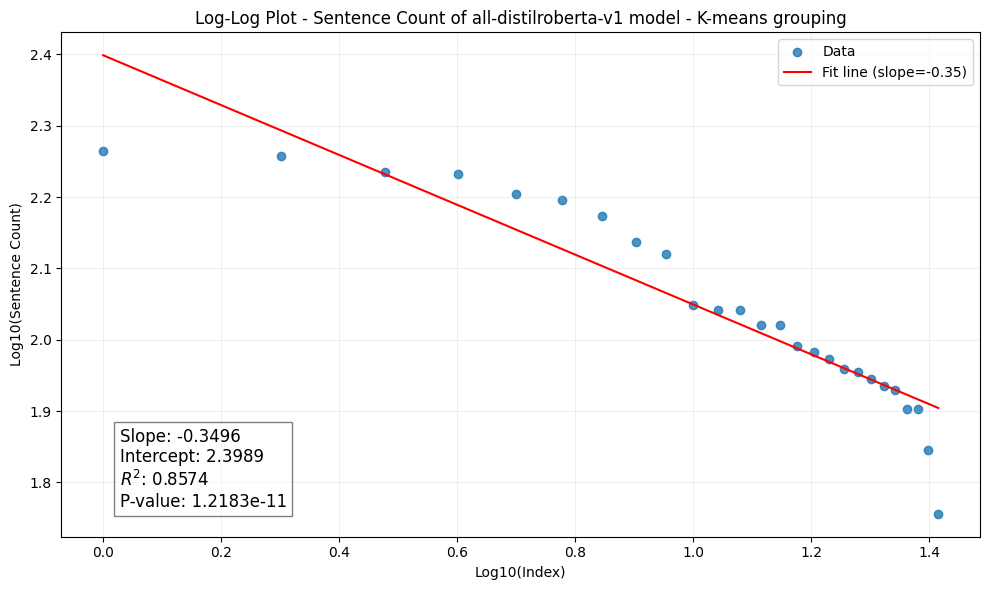


Regression Results for Sentence Count of all-distilroberta-v1 model - K-means grouping:
   - Slope: -0.3496
   - Intercept: 2.3989
   - R-squared: 0.8574
   - P-value: 1.2183e-11


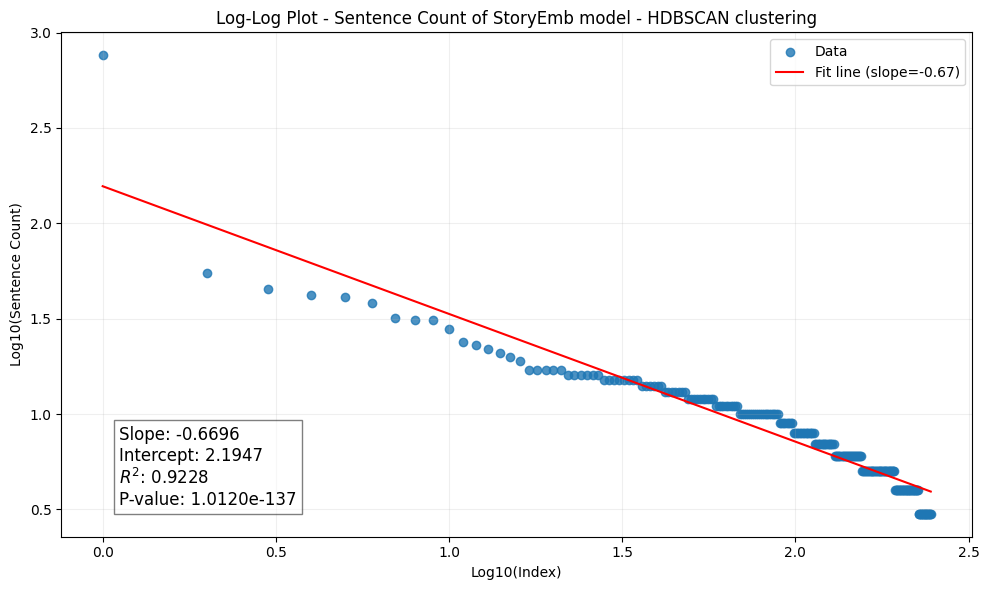


Regression Results for Sentence Count of StoryEmb model - HDBSCAN clustering:
   - Slope: -0.6696
   - Intercept: 2.1947
   - R-squared: 0.9228
   - P-value: 1.0120e-137


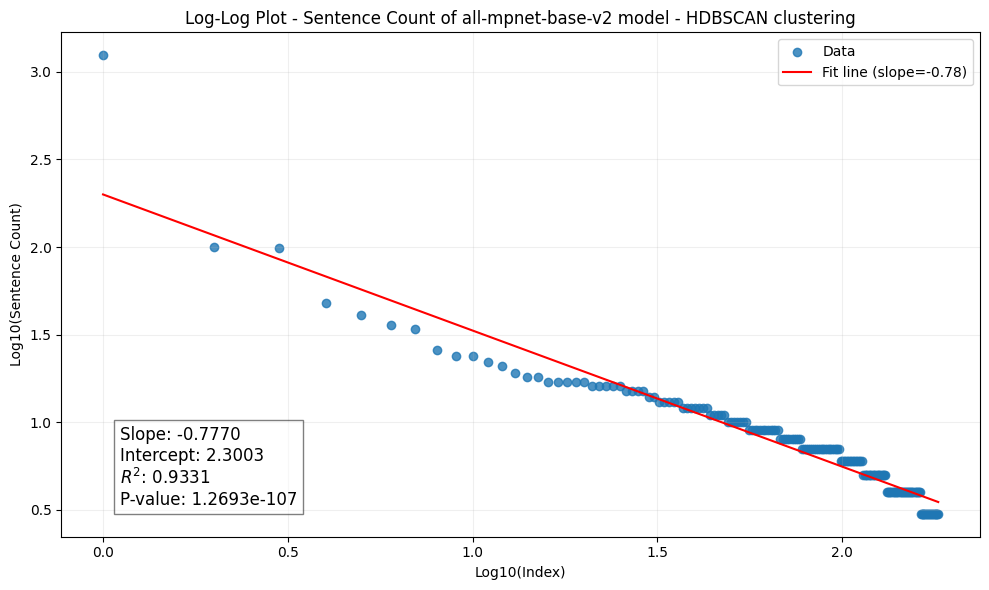


Regression Results for Sentence Count of all-mpnet-base-v2 model - HDBSCAN clustering:
   - Slope: -0.7770
   - Intercept: 2.3003
   - R-squared: 0.9331
   - P-value: 1.2693e-107


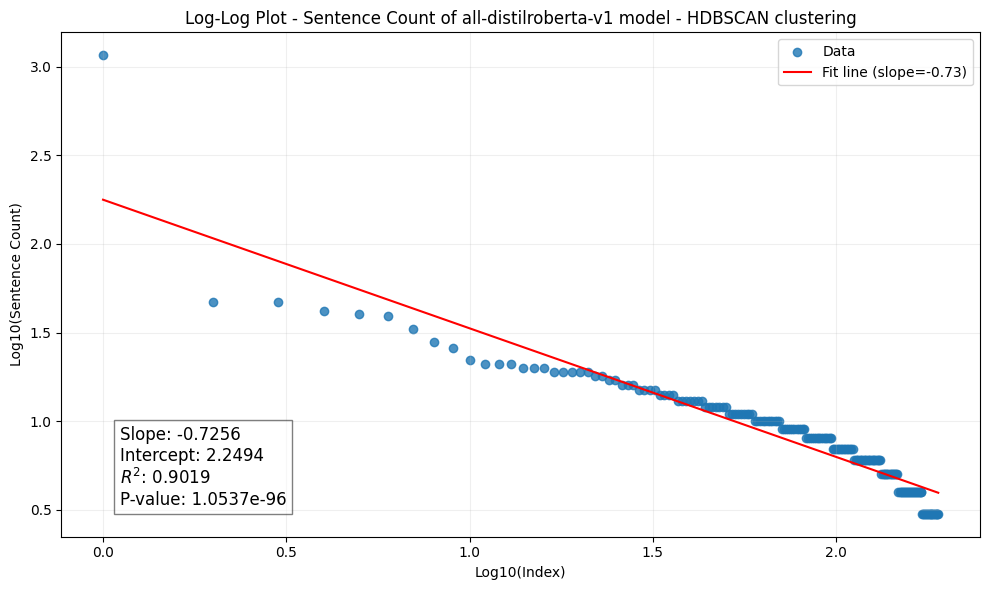


Regression Results for Sentence Count of all-distilroberta-v1 model - HDBSCAN clustering:
   - Slope: -0.7256
   - Intercept: 2.2494
   - R-squared: 0.9019
   - P-value: 1.0537e-96


In [ ]:
# Create the output directory if it doesn't exist
output_dir = "/content/images/"
os.makedirs(output_dir, exist_ok=True)

for vector, title in vectors:
    # Perform linear regression
    x, y, slope, intercept, r_val, p_val, y_pred = linear_regression(vector)

    # Create plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.8, label='Data')
    plt.plot(x, y_pred, 'r-', label=f'Fit line (slope={slope:.2f})')

    # Customize plot
    plt.title(f"Log-Log Plot - {title}")
    plt.xlabel('Log10(Index)')
    plt.ylabel('Log10(Sentence Count)')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend()

    text_x = min(x) + (max(x) - min(x)) * 0.02
    text_y = min(y) + (max(y) - min(y)) * 0.02

    plt.text(text_x, text_y,
             f"Slope: {slope:.4f}\nIntercept: {intercept:.4f}\n$R^2$: {r_val**2:.4f}\nP-value: {p_val:.4e}",
             fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    # Save the plot
    filename = re.sub(r'[^a-zA-Z0-9_\-]', '_', title) + "_loglog.png"
    save_path = os.path.join(output_dir, filename)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

    # Print regression statistics
    print(f"\nRegression Results for {title}:")
    print(f"   - Slope: {slope:.4f}")
    print(f"   - Intercept: {intercept:.4f}")
    print(f"   - R-squared: {r_val**2:.4f}")
    print(f"   - P-value: {p_val:.4e}")

In [ ]:
import shutil
from google.colab import files

# Define source directory and output zip file
source_dir = '/content/images'
zip_filename = '/content/images.zip'

# Zip the images folder
shutil.make_archive(base_name=zip_filename.replace('.zip', ''), format='zip', root_dir=source_dir)

# Download the zip file
files.download(zip_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>